**Topik:** AI-Enhanced Safety Monitoring in Automated Helmet Detection

**Anggota Kelompok 2:**
- Carissa Fabellina (2602071120)
- Dean Hans Felandio Setiadi Saputra (2602094206)
- Karen Regina Susanto (2602073403)
- Marvella Shera Devi (2602091040)
- Verren Angelina Saputra (2602093600)

# **Load Libraries dan Split Data**

Menginstall library yang akan digunakan dalam Helmet Detection.

In [1]:
!pip install tensorflow opencv-python matplotlib

Load setiap library yang akan digunakan dalam project.

In [2]:
import os
import cv2
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np

# !pip install tqdm --upgrade
from tqdm.notebook import tqdm

Load dataset dari web roboflow untuk data head dan helmet.

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="n8Y8tTc2NXDdJl1dAHqb")
project = rf.workspace("test-guvlx").project("head-direction-m08xh-ugvgo-xfoue")
version = project.version(1)
dataset = version.download("voc")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Head-Direction-1 in voc:: 100%|██████████| 1181/1181 [00:00<00:00, 3569.79it/s]


In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="n8Y8tTc2NXDdJl1dAHqb")
project = rf.workspace("svnmworkspace").project("helmet-detection-afijc-v7gyp")
version = project.version(1)
dataset = version.download("voc")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Helmet-detection-1 in voc:: 100%|██████████| 1051/1051 [00:00<00:00, 3728.81it/s]


Menampikan 5 contoh gambar dalam dataset head-direction, contoh di bawah ini menggunakan gambar dari folder train.

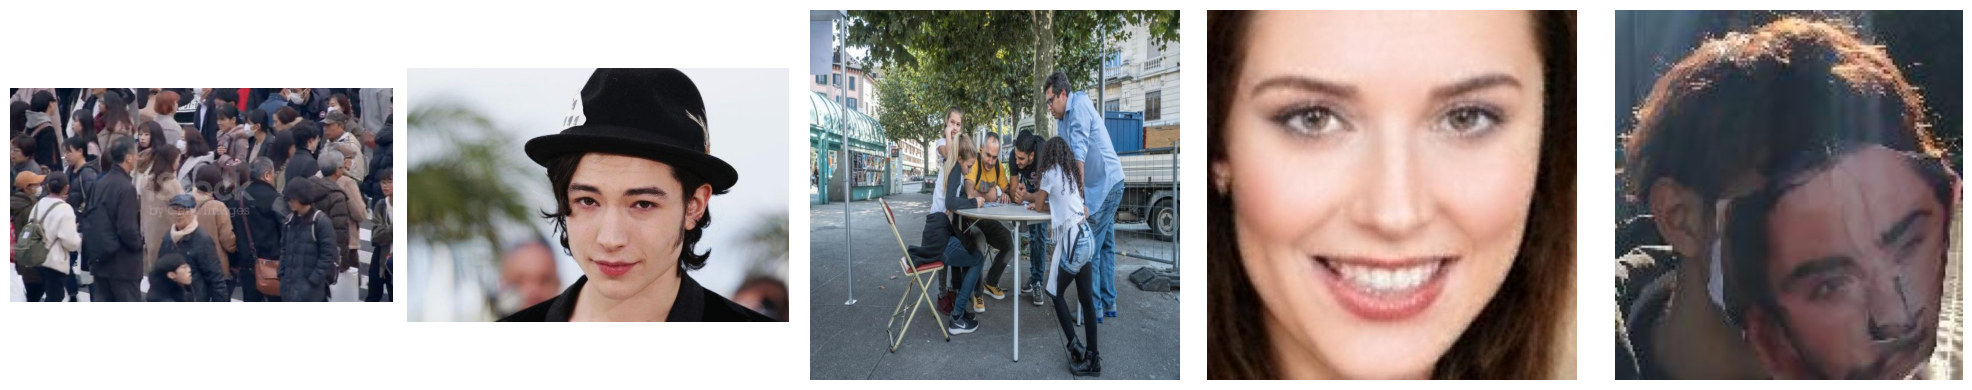

In [5]:
import matplotlib.pyplot as plt

path_to_images_head_train = '/content/Head-Direction-1/train'
image_files = [file for file in os.listdir(path_to_images_head_train) if file.endswith(('.jpg', '.jpeg', '.png'))]

images_per_row = 5
fig_width = 4 * images_per_row
fig_height = 4
fig, axes = plt.subplots(nrows=1, ncols=images_per_row, figsize=(fig_width, fig_height))

for i, image_file in enumerate(image_files[:images_per_row]):
    img_path = os.path.join(path_to_images_head_train, image_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img is not None:
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
    else:
        print(f"Failed to load image at: {img_path}")

plt.tight_layout()
plt.show()

Menampikan 5 contoh gambar dalam dataset helmet-direction, contoh di bawah ini menggunakan gambar dari folder train.

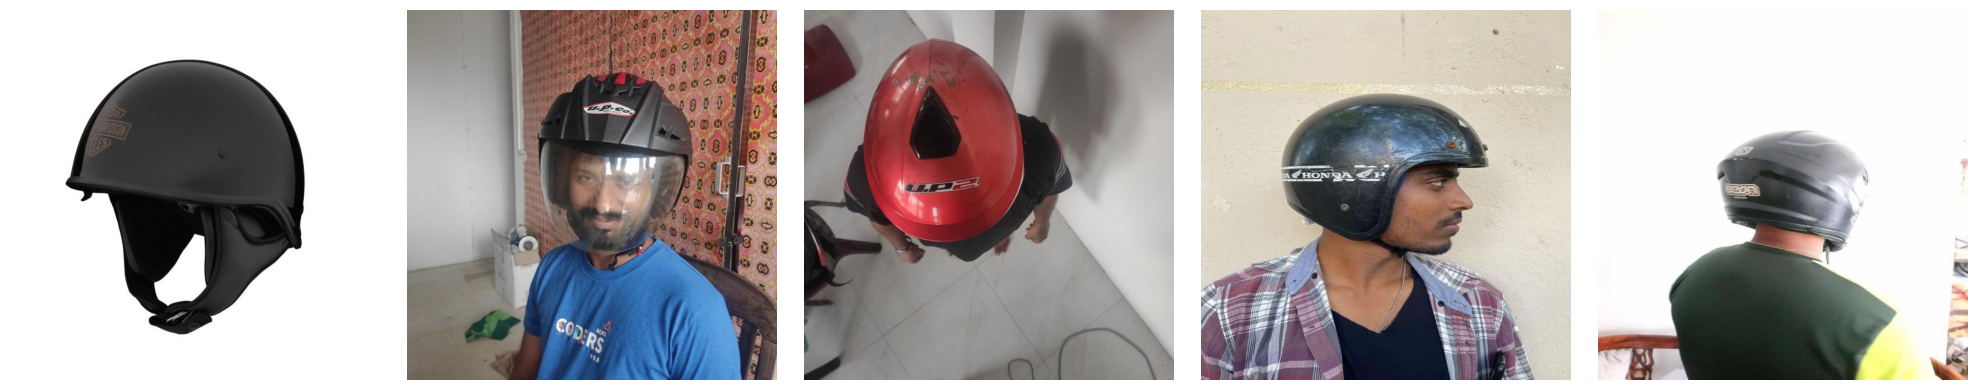

In [6]:
path_to_images = '/content/Helmet-detection-1/train'
image_files = [file for file in os.listdir(path_to_images) if file.endswith(('.jpg', '.jpeg', '.png'))]

images_per_row = 5

fig_width = 4 * images_per_row
fig_height = 4
fig, axes = plt.subplots(nrows=1, ncols=images_per_row, figsize=(fig_width, fig_height))

for i, image_file in enumerate(image_files[:images_per_row]):
    img_path = os.path.join(path_to_images, image_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img is not None:
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
    else:
        print(f"Failed to load image at: {img_path}")

plt.tight_layout()
plt.show()

Menghitung jumlah data dari masing-masing folder dataset.

In [7]:
import os

path_to_images_head_train = '/content/Head-Direction-1/train'
path_to_images_head_test = '/content/Helmet-detection-1/test'
path_to_images_head_val = '/content/Head-Direction-1/valid'
path_to_images_helmet_train = '/content/Helmet-detection-1/train'
path_to_images_helmet_test = '/content/Helmet-detection-1/test'
path_to_images_helmet_val = '/content/Helmet-detection-1/valid'

def count_images(directory):
    return len([file for file in os.listdir(directory) if file.endswith(('.jpg', '.jpeg', '.png'))])

head_train = count_images(path_to_images_head_train)
head_test = count_images(path_to_images_head_test)
head_val = count_images(path_to_images_head_val)
helmet_train = count_images(path_to_images_helmet_train)
helmet_test = count_images(path_to_images_helmet_test)
helmet_val = count_images(path_to_images_helmet_val)

print(f"Jumlah gambar dalam direktori head-train adalah: {head_train}")
print(f"Jumlah gambar dalam direktori head-test adalah: {head_test}")
print(f"Jumlah gambar dalam direktori head-val adalah: {head_val}")
print(f"Jumlah gambar dalam direktori helmet-train adalah: {helmet_train}")
print(f"Jumlah gambar dalam direktori helmet-test adalah: {helmet_test}")
print(f"Jumlah gambar dalam direktori helmet-val adalah: {helmet_val}")

Jumlah gambar dalam direktori head-train adalah: 411
Jumlah gambar dalam direktori head-test adalah: 83
Jumlah gambar dalam direktori head-val adalah: 118
Jumlah gambar dalam direktori helmet-train adalah: 349
Jumlah gambar dalam direktori helmet-test adalah: 83
Jumlah gambar dalam direktori helmet-val adalah: 91


Function untuk membaca file XML dalam format VOC yang berisi informasi mengenai koordinat dari bounding box (termasuk xmin, xmax, ymin, ymax) beserta labelnya.

In [8]:
import xml.etree.ElementTree as ET

def parse_voc_xml(xml_file, class_mapping):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    bboxes = []

    # Parse each object in the XML
    for obj in root.findall("object"):
        class_name = obj.find("name").text
        if class_name not in class_mapping:
            continue  # Ignore classes not in mapping

        class_id = class_mapping[class_name]
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        bboxes.append({
            'label': class_id,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return bboxes

Function untuk menunjukkan visualisasi dari bounding box dan label.

In [9]:
def visualize_bbox(image, bboxes, c):
    plt.subplot(2,4,c)
    img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    for i, bbox in enumerate(bboxes):
        x_min, y_min, x_max, y_max = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
        class_name = bbox['label']

        # Draw the bounding box
        cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 2)

        # Draw the label
        cv2.putText(img, str(class_name), (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # Display the image
    plt.imshow(img)
    plt.axis("off")

def visualize_keypoints(img_gray, keypoints, labels):
  restored_img_gray_1_color = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)

  res = restored_img_gray_1_color.copy()
  cv2.drawKeypoints(restored_img_gray_1_color, keypoints, res, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  plt.imshow(res)
  plt.title(labels)
  plt.show()

In [10]:
head_train_path = "Head-Direction-1/train/"
head_test_path = "Head-Direction-1/test/"
head_val_path = "Head-Direction-1/valid/"
helmet_train_path = "Helmet-detection-1/train/"
helmet_test_path = "Helmet-detection-1/test/"
helmet_val_path = "Helmet-detection-1/valid/"

In [11]:
train_path_img = './data/images/train/'
train_path_label = './data/labels/train/'
test_path_img = './data/images/test/'
test_path_label = './data/labels/test/'
val_path_img = './data/images/val/'
val_path_label = './data/labels/val/'

Function untuk membagi dataset ke dalam folder train, test, dan validation.

In [12]:
def train_test_split(path, mode):
  files = list(set([name[:-4] for name in os.listdir(path)]))

  random.seed(42)
  random.shuffle(files)

  os.makedirs(train_path_img, exist_ok = True)
  os.makedirs(train_path_label, exist_ok = True)
  os.makedirs(test_path_img, exist_ok = True)
  os.makedirs(test_path_label, exist_ok = True)
  os.makedirs(val_path_img, exist_ok = True)
  os.makedirs(val_path_label, exist_ok = True)
  p = 0

  if mode=="train":
    for filex in tqdm(files):
      if filex == 'classes':
          continue
      shutil.copy2(path + "/" + filex + '.jpg', f"{train_path_img}/" + filex + '.jpg' )
      shutil.copy2(path + "/" + filex + '.xml', f"{train_path_label}/" + filex + '.xml')

  elif mode=="test":
    for filex in tqdm(files):
        if filex == 'classes':
            continue
        shutil.copy2(path + "/" + filex + '.jpg', f"{test_path_img}/" + filex + '.jpg' )
        shutil.copy2(path + "/" + filex + '.xml', f"{test_path_label}/" + filex + '.xml')

  elif mode=="val":
    for filex in tqdm(files):
        if filex == 'classes':
            continue
        shutil.copy2(path + "/" + filex + '.jpg', f"{val_path_img}/" + filex + '.jpg' )
        shutil.copy2(path + "/" + filex + '.xml', f"{val_path_label}/" + filex + '.xml')

train_test_split(head_train_path,"train")
train_test_split(head_test_path,"test")
train_test_split(head_val_path,"val")
train_test_split(helmet_train_path,"train")
train_test_split(helmet_test_path,"test")
train_test_split(helmet_val_path,"val")

  0%|          | 0/411 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

# Train Model untuk Classify Object Based On Descriptors

Melakukan inisialisasi library untuk algoritma ORB dan AKAZE yang akan digunakan dalam mengekstraksi fitur.

In [13]:
orb = cv2.ORB_create()
akaze = cv2.AKAZE_create()

Function untuk membaca gambar dari folder. Kemudian, gambar diproses lebih lanjut dengan mengubah format warnanya dari BGR menjadi RGB, lalu grayscale. Setelah itu, Gaussian Blur diterapkan mengurangi noise dan equalisasi histogram untuk meningkatkan kontras. Lalu, label akan dihasilkan dan value yang dikembalikan berupa list gambar dan label.

In [14]:
def get_image_and_label(path):
  image_list = []
  label_list = []
  for img in os.listdir(path):
    image = cv2.imread(path+img) # read img
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # change to grayscale
    image = cv2.GaussianBlur(image, (11,11), 0)
    image = cv2.equalizeHist(image)
    label = img[:-4]+'.xml'
    image_list.append(image)
    label_list.append(label)
  return image_list, label_list

train_image_list, train_label_list = get_image_and_label(train_path_img)
test_image_list, test_label_list = get_image_and_label(test_path_img)
val_image_list, val_label_list = get_image_and_label(val_path_img)

print(len(train_image_list), len(test_image_list), len(val_image_list))

760 142 209


Melakukan mapping antara label berupa teks dan nilai numerik untuk mempermudah model dalam memproses data lebih lanjut.

In [15]:
label2id = {"0":0, "helmet":1}
id2label = {0:"head", 1:"helmet"}

Function untuk menggabungkan 2 set keypoints yang berasal dari ORB dan AKAZE. Selagi proses tersebut, terdapat pengecekan duplikasi juga di mana ketika jarak antara 2 keypoints kurang dari threshold, maka akan dianggap sebagai duplikat.

In [16]:
def combine_keypoints(keypoints1, keypoints2, threshold=5):
    combined = list(keypoints1)  # Initialize as a list, not a tuple
    for kp2 in keypoints2:
        if not any(cv2.norm(kp1.pt, kp2.pt) < threshold for kp1 in combined):
            combined.append(kp2)  # Append works on lists
    return combined

Mengekstrak fitur yang digunakan untuk training dengan melakukan parsing file XML terlebih dahulu untuk mendapatkan informasi mengenai bounding box. Lalu, dilanjutkan dengan memotong gambar sesuai dengan bounding boxnya. Dari gambar yang sudah dipotong itu, dilakukan ekstraksi keypoints dan descriptors menggunakan ORB dan AKAZE. Lalu, keypoints dan descriptors digabungkan dan fitur disimpan dalam list train_features.

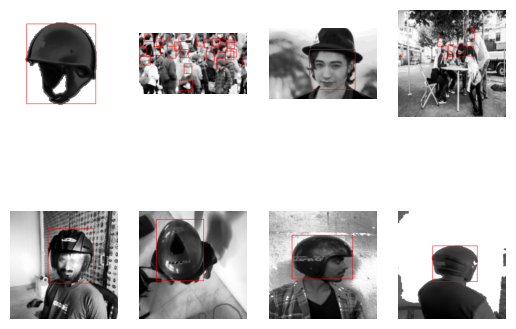

In [17]:
train_features = []
i=1

for img, label in zip(train_image_list, train_label_list):

  bboxes = parse_voc_xml(train_path_label+label, label2id) # bounding boxes & class of each bounding box

  if i<=8 :
    visualize_bbox(img, bboxes, i) # just visualize the first 8 data
  i+=1

  for bbox in bboxes:
    if bbox['xmin'] > img.shape[1]:continue
    cropped_image = img[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']] # crop
    if cropped_image.shape[0] < 32 or cropped_image.shape[1] < 32:
      cropped_image = cv2.resize(cropped_image, (32, 32))  # Example resizing

    keypoints_orb, descriptors_orb = orb.detectAndCompute(cropped_image, None)
    keypoints_akaze, descriptors_akaze = akaze.detectAndCompute(cropped_image, None)

    combined_keypoints = combine_keypoints(keypoints_orb, keypoints_akaze)

    if not combined_keypoints:
      continue
    if descriptors_orb is None :
      continue
    if descriptors_akaze is None:
      continue

    min_rows = min(descriptors_orb.shape[0], descriptors_akaze.shape[0])
    descriptors_orb = descriptors_orb[:min_rows]
    descriptors_akaze = descriptors_akaze[:min_rows]

    # Concatenate the descriptors
    combined_descriptors = np.hstack((descriptors_orb, descriptors_akaze))

    for kp in combined_keypoints:
      kp.pt = (kp.pt[1] + bbox['xmin'], kp.pt[0] + bbox['ymin'])

    train_features.append((img, combined_keypoints, combined_descriptors, bbox['label']))

plt.tight_layout
plt.show()

Melakukan hal yang sama seperti di atas, yakni ekstraksi fitur. Jika sebelumnya ekstraksi fitur dilakukan untuk training data, maka selanjutnya dilakukan untuk test data.

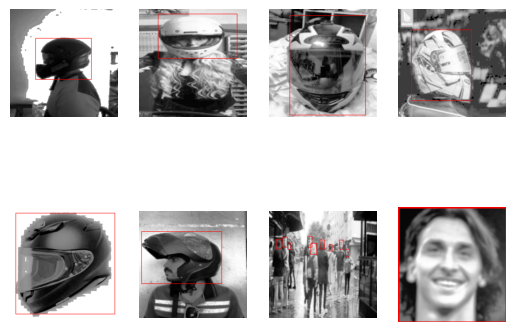

In [18]:
test_features = []
i=1

for img, label in zip(test_image_list, test_label_list):

  bboxes = parse_voc_xml(test_path_label+label, label2id)

  if i<=8 :
    visualize_bbox(img, bboxes, i) # just visualize the first 8 data
    i+=1

  for bbox in bboxes:
    if bbox['xmin'] > img.shape[1]:continue
    cropped_image = img[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']] # crop
    if cropped_image.shape[0] < 32 or cropped_image.shape[1] < 32:
      cropped_image = cv2.resize(cropped_image, (32, 32))  # Example resizing

    keypoints_orb, descriptors_orb = orb.detectAndCompute(cropped_image, None)
    keypoints_akaze, descriptors_akaze = akaze.detectAndCompute(cropped_image, None)

    combined_keypoints = combine_keypoints(keypoints_orb, keypoints_akaze)

    if not combined_keypoints:
      continue
    if descriptors_orb is None :
      continue
    if descriptors_akaze is None:
      continue

    min_rows = min(descriptors_orb.shape[0], descriptors_akaze.shape[0])
    descriptors_orb = descriptors_orb[:min_rows]
    descriptors_akaze = descriptors_akaze[:min_rows]

    # Concatenate the descriptors
    combined_descriptors = np.hstack((descriptors_orb, descriptors_akaze))

    for kp in combined_keypoints:
      kp.pt = (kp.pt[1] + bbox['xmin'], kp.pt[0] + bbox['ymin'])

    test_features.append((img, combined_keypoints, combined_descriptors, bbox['label']))

plt.tight_layout
plt.show()

Function untuk memvisualisasikan hasil dari ekstraksi fitur dalam keypoints yang terbentuk pada gambar.

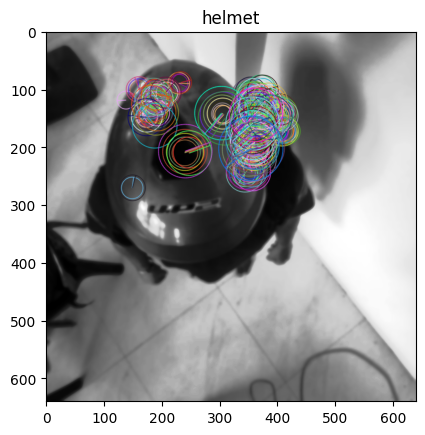

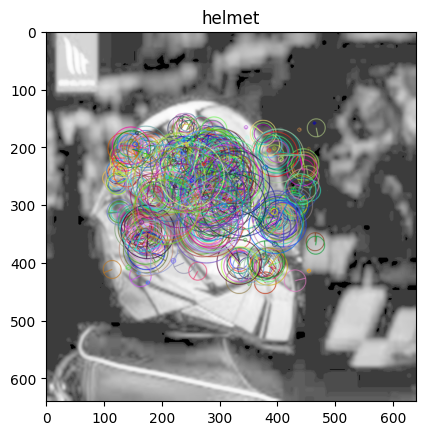

In [19]:
def draw_keypoints(idx, feature_list, label, extra_label):
  restored_img_gray_1_color = cv2.cvtColor(feature_list[idx][0], cv2.COLOR_GRAY2BGR)

  res = restored_img_gray_1_color.copy()
  cv2.drawKeypoints(restored_img_gray_1_color, feature_list[idx][1], res, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  plt.imshow(res)
  plt.title(id2label[label]+extra_label)

index = 3
draw_keypoints(index, train_features, train_features[index][3],"")
plt.show()
draw_keypoints(index, test_features, test_features[index][3],"")
plt.show()

Mendapatkan informasi mengenai descriptor, termasuk panjang maksimal, minimum, rata-rata, dan masing-masing dari panjang descriptornya.

In [20]:
desc_length = []
for (img, kp, desc, label) in train_features:
  desc_length.append(desc.shape[0])

print(max(desc_length))
print(min(desc_length))
print(np.sum(desc_length)/len(desc_length))
print(desc_length)

500
1
139.78685897435898
[162, 28, 156, 65, 64, 3, 201, 30, 150, 202, 30, 298, 204, 217, 187, 58, 20, 476, 144, 122, 213, 24, 8, 139, 48, 232, 279, 24, 42, 163, 265, 500, 145, 81, 44, 169, 86, 16, 329, 227, 16, 47, 361, 90, 84, 126, 210, 39, 22, 14, 189, 58, 395, 87, 154, 58, 69, 251, 42, 73, 7, 140, 17, 89, 11, 33, 43, 354, 162, 57, 202, 77, 115, 17, 500, 170, 89, 78, 156, 40, 255, 13, 38, 178, 68, 85, 15, 45, 6, 3, 1, 1, 7, 116, 356, 48, 42, 69, 45, 12, 44, 68, 84, 500, 476, 199, 12, 178, 250, 95, 227, 115, 500, 56, 24, 76, 232, 216, 285, 84, 177, 389, 20, 82, 46, 99, 126, 2, 269, 58, 140, 62, 67, 18, 69, 104, 220, 250, 86, 47, 196, 130, 23, 78, 98, 271, 108, 56, 335, 94, 247, 152, 308, 12, 59, 137, 500, 9, 66, 263, 193, 72, 235, 149, 12, 131, 36, 14, 79, 60, 240, 154, 105, 458, 49, 82, 4, 30, 68, 92, 389, 151, 135, 126, 80, 6, 201, 1, 249, 79, 500, 274, 135, 77, 222, 190, 274, 197, 332, 60, 54, 500, 78, 98, 24, 207, 240, 203, 26, 160, 27, 26, 28, 210, 98, 85, 182, 500, 325, 270, 1, 

Function untuk memastikan bahwa setiap descriptornya memiliki panjang maksimal 500. Ketika jumlah descriptornya kurang dari 500, maka fungsi akan menambahkan nilai 0.

In [21]:
def pad_or_truncate_descriptors(descriptors, max_descriptors=500):
    if descriptors.shape[0] > max_descriptors:
        return descriptors[:max_descriptors].flatten()
    else:
        padded = np.zeros((max_descriptors, descriptors.shape[1]))
        padded[:descriptors.shape[0]] = descriptors
        return padded.flatten()

padded_train_features = [pad_or_truncate_descriptors(desc, max_descriptors=100) for (img, kp, desc, label) in train_features]
padded_test_features = [pad_or_truncate_descriptors(desc, max_descriptors=100) for (img, kp, desc, label) in test_features]

Membuat dataset untuk melakukan training dan testing. Semua fitur pada training, testing, dan labelnya diconvert menjadi format NumPy Array.

In [22]:
padded_train_features = np.array(padded_train_features)  # Convert to NumPy array
padded_test_features = np.array(padded_test_features)  # Convert to NumPy array

train_labels = [col[3] for col in train_features]
train_labels = np.array(train_labels)  # Ensure labels are also a NumPy array
test_labels = [col[3] for col in test_features]
test_labels = np.array(test_labels)  # Ensure labels are also a NumPy array

In [23]:
from collections import Counter
Counter(train_labels)

Counter({1: 355, 0: 269})

In [24]:
print(len(train_labels), len(test_labels))

624 125


Mengimport library yang akan digunakan sekaligus mempersiapkan model Random Forest untuk dilatih menggunakan training data, lalu diuji pada testing data.

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train Random Forest
clf = RandomForestClassifier()
clf.fit(padded_train_features, train_labels)

RandomForestClassifier()

Melakukan evaluasi untuk hasil deteksi objek helm dan kepala melalui skor akurasi dan nilai confidence. Jika nilai confidencenya < 0.75, maka hasilnya masih kurang baik. Jika nilai confidencenya berada di antara 0.75 hingga 0.89, maka hasilnya cukup baik meskipun tidak sepenuhnya benar. Jika nilainya >= 0.90, maka hasilnya sudah sangat baik.

In [26]:
# Evaluate
probabilities = clf.predict_proba(padded_test_features)

y_pred = clf.predict(padded_test_features)
print("Accuracy:", accuracy_score(test_labels, y_pred))

for i, (predicted_class, prob) in enumerate(zip(y_pred, probabilities)):
    print(f"Sample {i}, Actual class: {id2label[test_labels[i]]}, Predicted class: {id2label[predicted_class]}, Confidence: {max(prob):.2f}")

Accuracy: 0.768
Sample 0, Actual class: helmet, Predicted class: helmet, Confidence: 0.80
Sample 1, Actual class: helmet, Predicted class: helmet, Confidence: 0.54
Sample 2, Actual class: helmet, Predicted class: helmet, Confidence: 0.51
Sample 3, Actual class: helmet, Predicted class: head, Confidence: 0.64
Sample 4, Actual class: helmet, Predicted class: helmet, Confidence: 0.70
Sample 5, Actual class: helmet, Predicted class: helmet, Confidence: 0.54
Sample 6, Actual class: head, Predicted class: helmet, Confidence: 0.53
Sample 7, Actual class: helmet, Predicted class: helmet, Confidence: 0.66
Sample 8, Actual class: head, Predicted class: head, Confidence: 0.66
Sample 9, Actual class: head, Predicted class: head, Confidence: 0.58
Sample 10, Actual class: head, Predicted class: head, Confidence: 0.66
Sample 11, Actual class: head, Predicted class: head, Confidence: 0.54
Sample 12, Actual class: head, Predicted class: helmet, Confidence: 0.58
Sample 13, Actual class: helmet, Predicte

Memvisualisasikan hasil dari prediksi objek helm dan kepala.

Actual label :  head
Actual label :  head
Actual label :  helmet
Actual label :  head
Actual label :  helmet


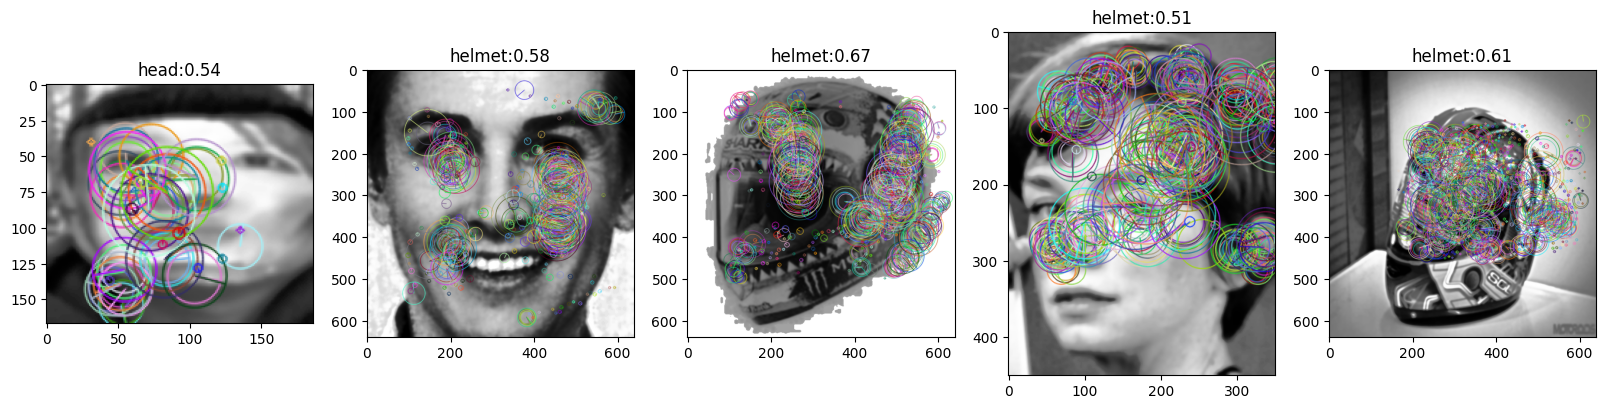

In [27]:
plt.figure(figsize=(20,20))
for r in range(1,6):
  plt.subplot(1,5,r)
  draw_keypoints(r+10, test_features, y_pred[r+10],":"+str(max(probabilities[r+10])))
  print("Actual label : ",id2label[test_features[r+10][3]])
plt.show()

Menyimpan model yang sudah dilatih dalam format joblib, supaya nantinya ketika ingin digunakan kembali tidak perlu dirun ulang dari awal.

In [28]:
import joblib

joblib.dump(clf, 'helmet_predictor_model.joblib')  # Menyimpan model prediksi

['helmet_predictor_model.joblib']

# Generate Bounding Boxes for Val Images using Cluster and Sliding Window

In [29]:
# pake val image list dan val label list utk xmlnya
# dapetin bounding box tiap image trus cocokin sama yg xml

Memproses validation data untuk memperoleh keypoint, deskriptor, fitur gambar, dan bounding box aktual dari label. Nantinya, validation data disimpan pada list val_features.

In [30]:
val_features = []
for img, label in zip(val_image_list, val_label_list):
  bboxes = parse_voc_xml(val_path_label+label, label2id)

  # Detect keypoints and descriptors
  keypoints_orb, descriptors_orb = orb.detectAndCompute(img, None)
  keypoints_akaze, descriptors_akaze = akaze.detectAndCompute(img, None)

  combined_keypoints = combine_keypoints(keypoints_orb, keypoints_akaze)

  min_rows = min(descriptors_orb.shape[0], descriptors_akaze.shape[0])
  descriptors_orb = descriptors_orb[:min_rows]
  descriptors_akaze = descriptors_akaze[:min_rows]

  combined_descriptors = np.hstack((descriptors_orb, descriptors_akaze))

  val_features.append((img, combined_keypoints, combined_descriptors, bboxes))

Melakukan clustering terhadap keypoints berdasarkan posisi koordinatnya menggunakan DBSCAN. Kemudian, menghitung ukuran rata-rata dari bounding box.

In [31]:
from sklearn.cluster import DBSCAN
val_window_sizes = []
for img, keypoints, descriptors, bboxes in val_features:
  # Cluster keypoints
  keypoint_coords = np.array([kp.pt for kp in keypoints])
  clustering = DBSCAN(eps=50, min_samples=3).fit(keypoint_coords)

  # Get unique cluster labels
  labels = clustering.labels_

  total_width = 0
  total_height = 0
  bbox_count = 0
  # Loop through unique clusters
  for label in np.unique(labels):
      if label == -1:  # Ignore noise points
          continue

      cluster_points = keypoint_coords[labels == label]
      # Calculate bounding box
      x_min = np.min(cluster_points[:, 0])
      x_max = np.max(cluster_points[:, 0])
      y_min = np.min(cluster_points[:, 1])
      y_max = np.max(cluster_points[:, 1])

      width = int(x_max)-int(x_min)
      height = int(y_max)-int(y_min)
      total_width += width
      total_height += height
      bbox_count += 1
  avg_width = total_width/bbox_count
  avg_height = total_height/bbox_count
  val_window_sizes.append((img, avg_width, avg_height, bboxes))

Function untuk menghitung nilai IoU.

In [32]:
def calculate_iou(box_a, box_p):
    # box_a and box_p are [x_min, y_min, x_max, y_max]

    # Intersection coordinates
    x_min_inter = max(box_a[0], box_p[0])
    y_min_inter = max(box_a[1], box_p[1])
    x_max_inter = min(box_a[2], box_p[2])
    y_max_inter = min(box_a[3], box_p[3])

    # Intersection area
    inter_width = max(0, x_max_inter - x_min_inter)
    inter_height = max(0, y_max_inter - y_min_inter)
    area_inter = inter_width * inter_height

    # Areas of both boxes
    area_a = (box_a[2] - box_a[0]) * (box_a[3] - box_a[1])
    area_p = (box_p[2] - box_p[0]) * (box_p[3] - box_p[1])

    # Union area
    area_union = area_a + area_p - area_inter

    # IoU
    iou = area_inter / area_union if area_union > 0 else 0
    return iou

Selanjutnya, deteksi bounding box dilakukan dengan menggunakan teknik sliding window, lalu hasilnya dibandingkan dengan bounding box yang sebenarnya. Kemudian, keypoints dan descriptor pada window dihitung. Setelah itu, prediksi bisa dilakukan menggunakan model.

Kemudian, bounding box dibandingkan dengan nilai IoUnya, dan nilai rata-rata dari IoU dihitung.

In [33]:
windows_data_list = []
final_bboxes = []
total_avg = 0
for k, (img, width, height, bboxes) in enumerate(val_window_sizes):
  i=-1
  window_size = (int(width), int(height))
  step_size = (int(width/2), int(height/2))

  num_of_bbox = len(bboxes)
  max_iou = np.zeros(num_of_bbox, dtype=float)
  max_iou_box_coord = np.zeros((num_of_bbox, 4), dtype=int)

  for y in range(0, img.shape[0] - window_size[1] + 1, step_size[1]):
      for x in range(0, img.shape[1] - window_size[0] + 1, step_size[0]):
          # Extract the window
          window = img[y:y + window_size[1], x:x + window_size[0]]
          i+=1
          cropped_input_orb_keypoints, cropped_input_orb_descriptors = orb.detectAndCompute(window, None)
          cropped_input_akaze_keypoints, cropped_input_akaze_descriptors = akaze.detectAndCompute(window, None)

          combined_keypoints = combine_keypoints(cropped_input_orb_keypoints, cropped_input_akaze_keypoints)

          if not combined_keypoints:
            continue
          if cropped_input_orb_descriptors is None :
            continue
          if cropped_input_akaze_descriptors is None:
            continue

          min_rows = min(cropped_input_orb_descriptors.shape[0], cropped_input_akaze_descriptors.shape[0])
          cropped_input_orb_descriptors = cropped_input_orb_descriptors[:min_rows]
          cropped_input_akaze_descriptors = cropped_input_akaze_descriptors[:min_rows]

          # Concatenate the descriptors
          combined_descriptors = np.hstack((cropped_input_orb_descriptors, cropped_input_akaze_descriptors))

          padded_desc = pad_or_truncate_descriptors(combined_descriptors, max_descriptors=100)
          padded_desc = np.array(padded_desc)

          input_prob = clf.predict_proba(padded_desc.reshape(1,-1))
          max_prob = np.max(input_prob)
          input_y_pred = clf.predict(padded_desc.reshape(1,-1))

          # if max_prob < 0.7:
          #   continue

          predicted_box = [x, y, x+window_size[0], y+window_size[1]]
          for b, bbox in enumerate(bboxes):
            actual_box = [bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']]

            iou = calculate_iou(actual_box, predicted_box)
            if iou > max_iou[b]:
              max_iou[b] = iou
              max_iou_box_coord[b] = predicted_box
  # utk img ini, generated bbox yg paling similar yg mana utk masing" actual bboxnya?
  iou_avg = np.mean(max_iou)
  total_avg += iou_avg
  final_bboxes.append((img, bboxes, max_iou_box_coord, max_iou, input_y_pred))

accuracy = total_avg/len(val_window_sizes)
print(accuracy)

0.22654786235640495


Memvisualisasikan bounding box aktual dan prediksi pada gambar agar dapat memudahkan evaluasi terhadap hasil.

[{'label': 0, 'xmin': 1, 'ymin': 1, 'xmax': 186, 'ymax': 244}] [[ 61   0 183 170]] iou : [0.45739512]


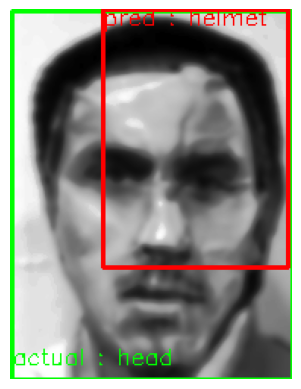

[{'label': 1, 'xmin': 119, 'ymin': 214, 'xmax': 573, 'ymax': 454}] [[120 282 360 471]] iou : [0.36518047]


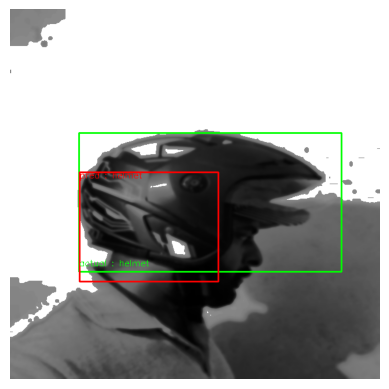

[{'label': 1, 'xmin': 1, 'ymin': 151, 'xmax': 465, 'ymax': 502}] [[ 98 174 197 290]] iou : [0.07051282]


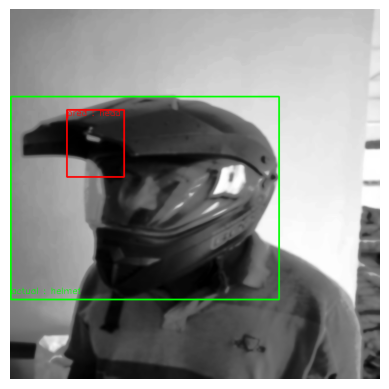

[{'label': 0, 'xmin': 45, 'ymin': 354, 'xmax': 134, 'ymax': 475}, {'label': 0, 'xmin': 449, 'ymin': 351, 'xmax': 527, 'ymax': 489}, {'label': 0, 'xmin': 189, 'ymin': 133, 'xmax': 213, 'ymax': 171}, {'label': 0, 'xmin': 241, 'ymin': 126, 'xmax': 287, 'ymax': 208}, {'label': 0, 'xmin': 345, 'ymin': 115, 'xmax': 393, 'ymax': 206}, {'label': 0, 'xmin': 451, 'ymin': 112, 'xmax': 511, 'ymax': 215}, {'label': 0, 'xmin': 404, 'ymin': 139, 'xmax': 423, 'ymax': 172}, {'label': 0, 'xmin': 537, 'ymin': 124, 'xmax': 554, 'ymax': 153}, {'label': 0, 'xmin': 534, 'ymin': 264, 'xmax': 573, 'ymax': 337}, {'label': 0, 'xmin': 555, 'ymin': 216, 'xmax': 585, 'ymax': 273}, {'label': 0, 'xmin': 580, 'ymin': 147, 'xmax': 597, 'ymax': 175}, {'label': 0, 'xmin': 610, 'ymin': 134, 'xmax': 629, 'ymax': 164}] [[  0   0 564 548]
 [  0   0 564 548]
 [  0   0 564 548]
 [  0   0 564 548]
 [  0   0 564 548]
 [  0   0 564 548]
 [  0   0 564 548]
 [  0   0 564 548]
 [  0   0 564 548]
 [  0   0 564 548]
 [  0   0   0   0]

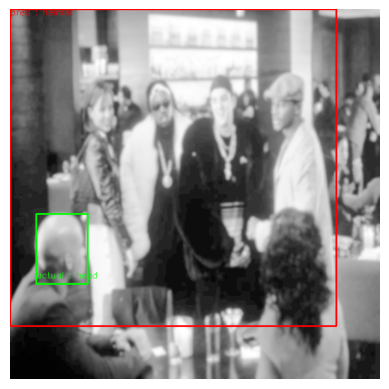

[{'label': 1, 'xmin': 136, 'ymin': 63, 'xmax': 527, 'ymax': 378}] [[136 110 273 221]] iou : [0.12346852]


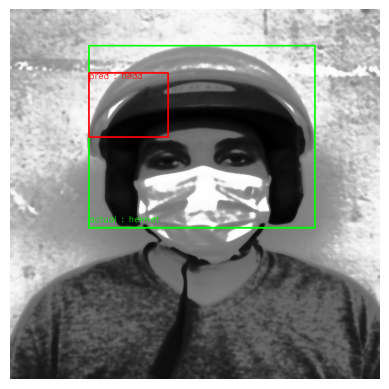

[{'label': 1, 'xmin': 136, 'ymin': 73, 'xmax': 441, 'ymax': 293}, {'label': 1, 'xmin': 85, 'ymin': 72, 'xmax': 534, 'ymax': 583}] [[  0   0 466 532]
 [  0   0 466 532]] iou : [0.27066056 0.58015631]


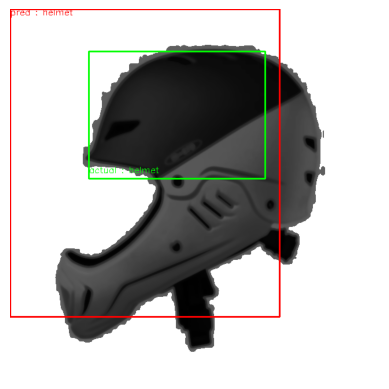

[{'label': 0, 'xmin': 1, 'ymin': 1, 'xmax': 235, 'ymax': 317}] [[  0 156 168 261]] iou : [0.23680266]


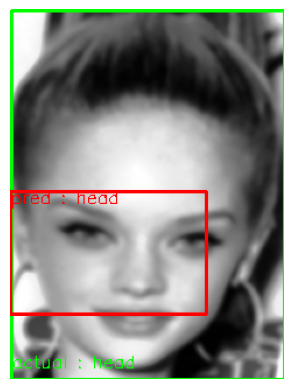

[{'label': 0, 'xmin': 1, 'ymin': 1, 'xmax': 225, 'ymax': 225}] [[ 70  73 210 220]] iou : [0.41015625]


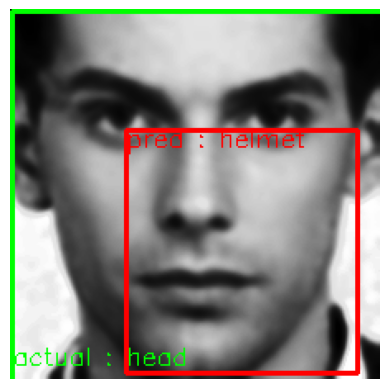

[{'label': 1, 'xmin': 117, 'ymin': 82, 'xmax': 546, 'ymax': 608}] [[200 145 600 436]] iou : [0.41714726]


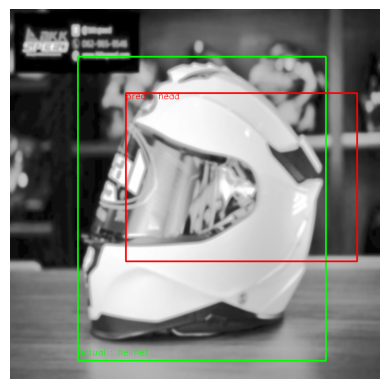

[{'label': 0, 'xmin': 545, 'ymin': 127, 'xmax': 618, 'ymax': 242}, {'label': 0, 'xmin': 528, 'ymin': 195, 'xmax': 597, 'ymax': 294}, {'label': 0, 'xmin': 445, 'ymin': 185, 'xmax': 491, 'ymax': 267}, {'label': 0, 'xmin': 197, 'ymin': 255, 'xmax': 254, 'ymax': 348}] [[  0   0 576 577]
 [  0   0 576 577]
 [  0   0 576 577]
 [  0   0 576 577]] iou : [0.01057293 0.01420921 0.01134941 0.01594996]


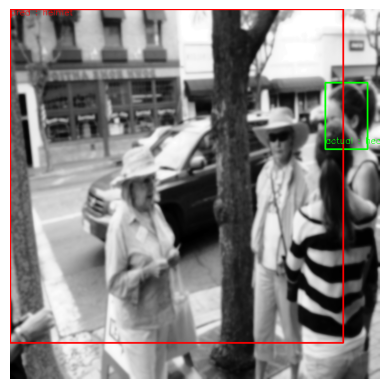

[{'label': 1, 'xmin': 97, 'ymin': 66, 'xmax': 566, 'ymax': 580}] [[  0   0 483 521]] iou : [0.55389982]


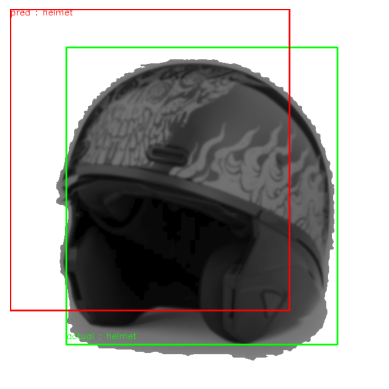

[{'label': 1, 'xmin': 33, 'ymin': 129, 'xmax': 561, 'ymax': 505}] [[185 159 555 478]] iou : [0.59452571]


In [34]:
def visualize_all_bbox(image, actual_bboxes, generated_bboxes, labels):
    # Ensure grayscale image is converted to RGB for visualization
    img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    for bbox, gbox, label in zip(actual_bboxes, generated_bboxes, labels):
        actual_label, x_min, y_min, x_max, y_max = bbox['label'], bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
        x_min_g, y_min_g, x_max_g, y_max_g = gbox
        # Draw the bounding box
        cv2.rectangle(img, (x_min,y_min), (x_max, y_max), (0, 255, 0), 2) #actual -> green
        cv2.rectangle(img, (x_min_g,y_min_g), (x_max_g, y_max_g), (255, 0, 0), 2) # generated -> red

        # Draw the label
        cv2.putText(img, "actual : "+str(id2label[actual_label]), (x_min, y_max - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        cv2.putText(img, "pred : "+str(id2label[label]), (x_min_g, y_min_g + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # Display the image
    plt.imshow(img)
    plt.axis("off")

for i, (img, bboxes, max_iou_box_coord, max_iou, pred) in enumerate(final_bboxes):
  print(bboxes, max_iou_box_coord, "iou : "+str(max_iou))
  if(i<=10):
    visualize_all_bbox(img, bboxes, max_iou_box_coord, pred)
    plt.show()
  else : break

# New Image

Memuat gambar yang dijadikan sebagai input, lalu memprosesnya lebih lanjut seperti step-step yang sudah dijelaskan di atas.

Text(0.5, 1.0, 'Input Image')

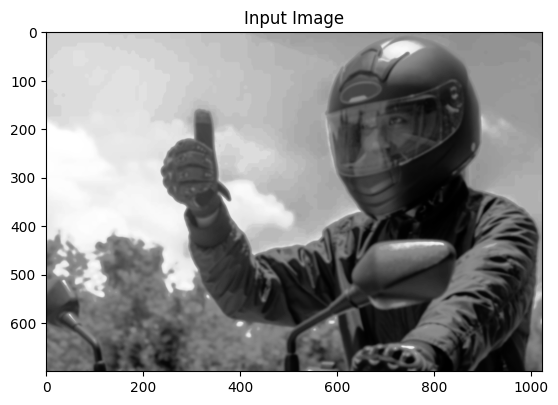

In [35]:
# Load Input Image
input_image = cv2.imread("helmet.jpg")
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)
input_image = cv2.GaussianBlur(input_image, (11,11), 0)
input_image = cv2.equalizeHist(input_image)

plt.imshow(input_image, cmap='gray')
plt.title('Input Image')

## Clustering

Mendeteksi keypoints dan mengekstrak descriptor, lalu divisualisasikan hasilnya.

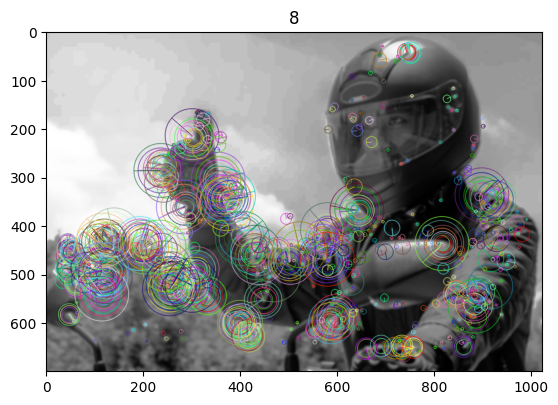

In [36]:
# Detect keypoints and descriptors
keypoints_orb, descriptors_orb = orb.detectAndCompute(input_image, None)
keypoints_akaze, descriptors_akaze = akaze.detectAndCompute(input_image, None)

combined_keypoints = combine_keypoints(keypoints_orb, keypoints_akaze)

min_rows = min(descriptors_orb.shape[0], descriptors_akaze.shape[0])
descriptors_orb = descriptors_orb[:min_rows]
descriptors_akaze = descriptors_akaze[:min_rows]

# Concatenate the descriptors
combined_descriptors = np.hstack((descriptors_orb, descriptors_akaze))

restored_img_gray_color = cv2.cvtColor(input_image, cv2.COLOR_GRAY2BGR)

res = restored_img_gray_color.copy()
cv2.drawKeypoints(restored_img_gray_color, combined_keypoints, res, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(res)
plt.title(label)
plt.show()

Melakukan clustering keypoints kembali dengan menggunakan DBSCAN sama seperti sebelumnya.

In [37]:
# Cluster keypoints
from sklearn.cluster import DBSCAN
keypoint_coords = np.array([kp.pt for kp in combined_keypoints])
clustering = DBSCAN(eps=50, min_samples=3).fit(keypoint_coords)

# Get unique cluster labels
labels = clustering.labels_

# Initialize list for bounding boxes
input_image_bounding_boxes = []

# Loop through unique clusters
total_height = 0
total_width = 0
c=0
for label in np.unique(labels):
    if label == -1:  # Ignore noise points
        continue

    cluster_points = keypoint_coords[labels == label]
    # Calculate bounding box
    x_min = np.min(cluster_points[:, 0])
    x_max = np.max(cluster_points[:, 0])
    y_min = np.min(cluster_points[:, 1])
    y_max = np.max(cluster_points[:, 1])
    c+=1

    width = int(x_max)-int(x_min)
    height = int(y_max)-int(y_min)
    total_height += height
    total_width += width

    input_image_bounding_boxes.append((int(x_min), int(y_min), int(x_max), int(y_max)))

avg_width = int(total_width/c)
avg_height = int(total_height/c)

Mencetak hasil dari bounding box yang telah dibuat.

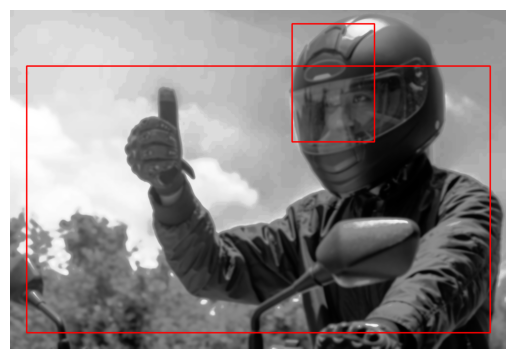

In [38]:
output_image = cv2.cvtColor(input_image, cv2.COLOR_GRAY2BGR)
for bbox in input_image_bounding_boxes:
    x_min, y_min, x_max, y_max = bbox
    cv2.rectangle(output_image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

    # Display the image
plt.imshow(output_image)
plt.axis("off")
plt.show()

Melakukan object classification dalam bounding box.

In [39]:
# classify object in each bounding boxes
cropped_input_sift_descriptors_list = []
for bbox in input_image_bounding_boxes:
    x_min, y_min, x_max, y_max = bbox
    cropped_input_image = input_image[y_min:y_max, x_min:x_max]
    cropped_input_orb_keypoints, cropped_input_orb_descriptors = orb.detectAndCompute(input_image, None)
    cropped_input_akaze_keypoints, cropped_input_akaze_descriptors = akaze.detectAndCompute(input_image, None)

    combined_keypoints = combine_keypoints(cropped_input_orb_keypoints, cropped_input_akaze_keypoints)
    if not combined_keypoints:
      continue
    if cropped_input_orb_descriptors is None :
      continue
    if cropped_input_akaze_descriptors is None:
      continue

    min_rows = min(cropped_input_orb_descriptors.shape[0], cropped_input_akaze_descriptors.shape[0])
    cropped_input_orb_descriptors = cropped_input_orb_descriptors[:min_rows]
    cropped_input_akaze_descriptors = cropped_input_akaze_descriptors[:min_rows]

    # Concatenate the descriptors
    combined_descriptors = np.hstack((cropped_input_orb_descriptors, cropped_input_akaze_descriptors))

    cropped_input_sift_descriptors_list.append(combined_descriptors)

padded_input_sift_descriptors_list = [pad_or_truncate_descriptors(desc, max_descriptors=100) for desc in cropped_input_sift_descriptors_list]
padded_input_sift_descriptors_list = np.array(padded_input_sift_descriptors_list)

# Evaluate
input_probabilities = clf.predict_proba(padded_input_sift_descriptors_list)
input_y_pred = clf.predict(padded_input_sift_descriptors_list)

used_bboxes = []
for i, (predicted_class, prob) in enumerate(zip(input_y_pred, input_probabilities)):
  print(f"Bbox {i}, Predicted class: {predicted_class}, Confidence: {max(prob):.2f}")
  if(max(prob)>0.6):
    used_bboxes.append((input_image_bounding_boxes[i], predicted_class))

Bbox 0, Predicted class: 1, Confidence: 0.59
Bbox 1, Predicted class: 1, Confidence: 0.59


Memvisualisasikan hasil prediksi gambar.

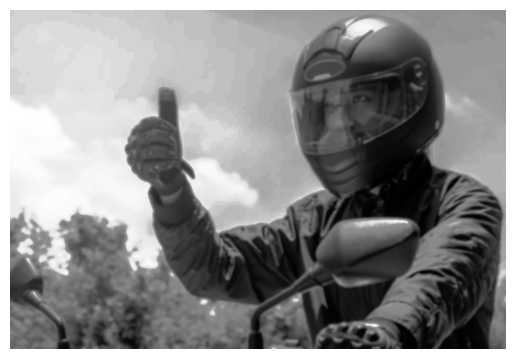

In [40]:
def visualize_pred(image, bboxes):
    # Ensure grayscale image is converted to RGB for visualization
    img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    for i, (bbox, label) in enumerate(bboxes):
        x_min, y_min, x_max, y_max = bbox
        # class_name = bbox['label']

        # Draw the bounding box
        cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 2)

        # Draw the label
        cv2.putText(img, str(id2label[label]), (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # Display the image
    plt.imshow(img)
    plt.axis("off")

visualize_pred(input_image, used_bboxes)
plt.show()

## Sliding Window

Melakukan object detection menggunakan sliding window, di mana setiap windownya dievaluasi dengan cara mengekstrak fitur menggunakan ORB dan AKAZE, menggabungkan descriptor, dan melakukan klasifikasi menggunakan model clf.

[]

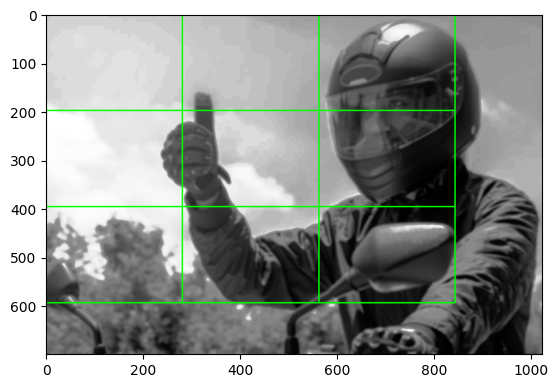

In [41]:
all_windows = []
window_size = (avg_width, avg_height)  # Window width and height
step_size = (int(avg_width/2), int(avg_height/2))  # Step size for x and y
for y in range(0, input_image.shape[0] - window_size[1] + 1, step_size[1]):
    for x in range(0, input_image.shape[1] - window_size[0] + 1, step_size[0]):
        # Extract the window
        window = input_image[y:y + window_size[1], x:x + window_size[0]]
        all_windows.append((x, y, window))

clone = cv2.cvtColor(input_image, cv2.COLOR_GRAY2BGR)

# extract features from each windows
windows_descriptors_list = []
windows_idx_list = []
for i, (x, y, window) in enumerate(all_windows):
    cropped_input_orb_keypoints, cropped_input_orb_descriptors = orb.detectAndCompute(window, None)
    cropped_input_akaze_keypoints, cropped_input_akaze_descriptors = akaze.detectAndCompute(window, None)

    combined_keypoints = combine_keypoints(cropped_input_orb_keypoints, cropped_input_akaze_keypoints)
    if not combined_keypoints:
      continue
    if cropped_input_orb_descriptors is None :
      continue
    if cropped_input_akaze_descriptors is None:
      continue

    min_rows = min(cropped_input_orb_descriptors.shape[0], cropped_input_akaze_descriptors.shape[0])
    cropped_input_orb_descriptors = cropped_input_orb_descriptors[:min_rows]
    cropped_input_akaze_descriptors = cropped_input_akaze_descriptors[:min_rows]

    # Concatenate the descriptors
    combined_descriptors = np.hstack((cropped_input_orb_descriptors, cropped_input_akaze_descriptors))

    windows_idx_list.append(i)
    windows_descriptors_list.append(combined_descriptors)

    # Display the window
    cv2.rectangle(clone, (x, y), (x + window_size[0], y + window_size[1]), (0, 255, 0), 2)
plt.imshow(clone)
plt.plot()

Mempersiapkan data descriptor untuk sliding window. Lalu, melakukan evaluasi dengan menggunakan model klasifikasi. Kemudian, dilakukan seleksi terhadap window yang valid saja dengan batas maksimal probabilitasnya sebesar 0.7.

In [42]:
padded_input_windows_descriptors_list = [pad_or_truncate_descriptors(desc, max_descriptors=100) for desc in windows_descriptors_list]
padded_input_windows_descriptors_list = np.array(padded_input_windows_descriptors_list)

# Evaluate
input_probabilities = clf.predict_proba(padded_input_windows_descriptors_list)
input_y_pred = clf.predict(padded_input_windows_descriptors_list)

used_windows = []
for i, (predicted_class, prob) in enumerate(zip(input_y_pred, input_probabilities)):
  print(f"Window {windows_idx_list[i]}, Predicted class: {predicted_class}, Confidence: {max(prob):.2f}")
  if(max(prob)>0.7):
    used_windows.append((windows_idx_list[i], predicted_class))

Window 0, Predicted class: 1, Confidence: 0.71
Window 1, Predicted class: 1, Confidence: 0.62
Window 2, Predicted class: 1, Confidence: 0.64
Window 3, Predicted class: 1, Confidence: 0.58


Function untuk memvisualisasikan hasil prediksi pada window.

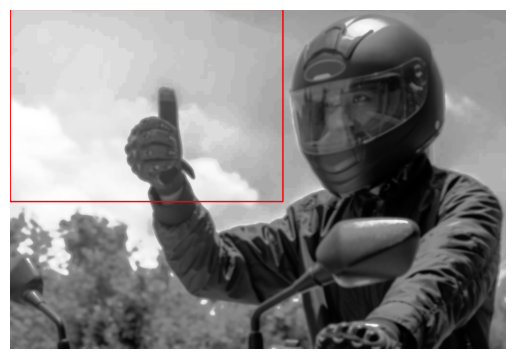

In [43]:
def visualize_window_pred(image, used_windows):
    # Ensure grayscale image is converted to RGB for visualization
    img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    for (i, label) in (used_windows):
        x,y,window = all_windows[i]
        # Draw the bounding box
        cv2.rectangle(img, (x,y), (x + window_size[0], y + window_size[1]), (255, 0, 0), 2)

        # Draw the label
        cv2.putText(img, str(id2label[label]), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # Display the image
    plt.imshow(img)
    plt.axis("off")

visualize_window_pred(input_image, used_windows)
plt.show()